## Import Library

In [1]:
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend" #for Mac
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
#os.environ["CUDA_VISIBLE_DEVICES"]='1'
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
pd.options.display.max_columns = None

## Load Data and Preprocessing

In [2]:
import datatable
df_amc = datatable.fread('./1205_asan_raw_v1.csv', na_strings=['']).to_pandas()
df_eumc = datatable.fread('./1204_eumc_raw.csv', na_strings=['']).to_pandas()
df_snuh = datatable.fread("./snuh_2004_2019_v2.csv", na_strings=['']).to_pandas()
df_snuh['sex'] = np.where(df_snuh['sex']=='M', 1, 0)
df_eumc['sex'] = np.where(df_eumc['sex']==1, 1, 0)
df_snuh = df_snuh[df_snuh['asa'].notnull()].reset_index(drop=True)
df_amc = df_amc[df_amc['ASA'].notnull()].reset_index(drop=True)
df_snuh['asa'] = np.where(df_snuh['asa'].isin([1, 2]), 1, 2)
df_amc['asa'] = np.where(df_amc['ASA'].isin([1, 2]), 1, 2)

df_amc['bmi'] = df_amc['weight'] / (df_amc['height']/100)**2

### Variable Selection

In [3]:
var_list = ['age','bmi','sex', 'preop_alb','preop_bun','preop_cr','preop_glu','preop_gpt','preop_got','preop_hb','preop_k','preop_na','preop_plt','preop_wbc', 'asa']

## Train Test split

In [4]:
X_snuh = df_snuh[var_list]

## Missing Imputation
X_snuh.fillna(df_snuh.median(), inplace=True)
y_snuh = df_snuh['death30']
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_snuh, y_snuh, test_size=0.2, stratify=y_snuh, random_state=1004)

/home/khl256/anaconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [5]:
X_train_1 = X_train.drop(columns=['asa'])
X_train_2 = X_train[['asa']]
#X_train_2['asa'] = np.where(X_train_2['asa'].isin([1]), 0, 1) #binary code
X_train_2 = pd.get_dummies(X_train_2['asa'], prefix='asa') # One-hot code
X_train_3 = X_train_2['asa_2']
X_train_2 = X_train_2['asa_1']

X_test_1 = X_test.drop(columns=['asa'])
X_test_2 = X_test[['asa']]
#X_test_2['asa'] = np.where(X_test_2['asa'].isin([1]), 0, 1)
X_test_2 = pd.get_dummies(X_test_2['asa'], prefix='asa') # One-hot code
X_test_3 = X_test_2['asa_2']
X_test_2 = X_test_2['asa_1']

In [6]:
scaler = StandardScaler()
scaler.fit(X_train_1)
X_train_1 = pd.DataFrame(scaler.transform(X_train_1))
X_test_1 = pd.DataFrame(scaler.transform(X_test_1))

## Model

In [7]:
def my_model(hidden_layer_num, node_size, drop_out_rate, learning_rate):
    
    ### clear memory
    if K.backend() == 'tensorflow':
        K.clear_session()

    ### Input Layer
    input_x = keras.layers.Input(shape=(14, ), name='input_feature')
    input_adjust_1 = keras.layers.Input(shape=(1, ), name='adjust_feature_asa_1')
    input_adjust_2 = keras.layers.Input(shape=(1, ), name='adjust_feature_asa_2')
    
    ## Feature Generation Part 
    
    ### Hidden Layer 1
    hidden_1_1 = keras.layers.Dense(node_size)(input_x)
    hidden_1_2 = keras.layers.BatchNormalization()(hidden_1_1)
    hidden_1_3 = keras.layers.ReLU()(hidden_1_2)
    hidden_1_4 = keras.layers.Dropout(drop_out_rate)(hidden_1_3)
    
    ### Hidden Layer 2
    hidden_2_1 = keras.layers.Dense(node_size)(hidden_1_4)
    hidden_2_2 = keras.layers.BatchNormalization()(hidden_2_1)
    hidden_2_3 = keras.layers.ReLU()(hidden_2_2)
    hidden_2_4 = keras.layers.Dropout(drop_out_rate)(hidden_2_3)
    
    ### Hidden Layer 3
    hidden_3_1 = keras.layers.Dense(node_size)(hidden_2_4)
    hidden_3_2 = keras.layers.BatchNormalization()(hidden_3_1)
    hidden_3_3 = keras.layers.ReLU()(hidden_3_2)
    hidden_3_4 = keras.layers.Dropout(drop_out_rate)(hidden_3_3)
    
    ### Hidden Layer 4
    hidden_4_1 = keras.layers.Dense(node_size)(hidden_3_4)
    hidden_4_2 = keras.layers.BatchNormalization()(hidden_4_1)
    hidden_4_3 = keras.layers.ReLU()(hidden_4_2)
    hidden_4_4 = keras.layers.Dropout(drop_out_rate)(hidden_4_3)
    
    ### Hidden Layer 5
    hidden_5_1 = keras.layers.Dense(node_size)(hidden_4_4)
    hidden_5_2 = keras.layers.BatchNormalization()(hidden_5_1)
    hidden_5_3 = keras.layers.ReLU()(hidden_5_2)
    hidden_5_4 = keras.layers.Dropout(drop_out_rate)(hidden_5_3)
    
    
    ##  Adjust Layers (ASA Class - 1~2, 2~5)
    adjust_1_1 = tf.multiply(hidden_5_4, input_adjust_1)
    adjust_1_2 = tf.multiply(hidden_5_4, input_adjust_2)
    adjust_1 = keras.layers.concatenate([adjust_1_1, adjust_1_2])
    
    ### Hidden Layer 2_1
    hidden_ad_1_1 = keras.layers.Dense(500)(adjust_1)
    hidden_ad_1_2 = keras.layers.BatchNormalization()(hidden_ad_1_1)
    hidden_ad_1_3 = keras.layers.ReLU()(hidden_ad_1_2)
    hidden_ad_1_4 = keras.layers.Dropout(drop_out_rate)(hidden_ad_1_3)
    
    ### Hidden Layer 2_1
    #hidden_ad_2_1 = keras.layers.Dense(node_size)(hidden_ad_1_4)
    #hidden_ad_2_2 = keras.layers.BatchNormalization()(hidden_ad_2_1)
    #hidden_ad_2_3 = keras.layers.ReLU()(hidden_ad_2_2)
    #hidden_ad_2_4 = keras.layers.Dropout(drop_out_rate)(hidden_ad_2_3)
    
    output = keras.layers.Dense(1, activation='sigmoid', name='output')(hidden_ad_1_3)
    
    model = keras.Model(inputs=[input_x, input_adjust_1, input_adjust_2], outputs=[output])
    
    ### Compile
    model.compile(optimizer= keras.optimizers.Adam(learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=["accuracy"])
    
    return model

In [8]:
model = my_model(hidden_layer_num=5, node_size=1000, drop_out_rate=0.4, learning_rate=0.001)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_feature (InputLayer)      [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1000)         15000       input_feature[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1000)         4000        dense[0][0]                      
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1000)         0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
model.fit((X_train_1, X_train_2, X_train_3), y_train, batch_size=2**8, epochs=7, validation_data=((X_test_1, X_test_2, X_test_3), y_test))

Epoch 1/7
659/659 [==============================] - 6s 10ms/step - loss: 0.0243 - accuracy: 0.9950 - val_loss: 0.0108 - val_accuracy: 0.9977
Epoch 2/7
659/659 [==============================] - 6s 9ms/step - loss: 0.0118 - accuracy: 0.9977 - val_loss: 0.0112 - val_accuracy: 0.9976
Epoch 3/7
659/659 [==============================] - 6s 9ms/step - loss: 0.0114 - accuracy: 0.9977 - val_loss: 0.0111 - val_accuracy: 0.9977
Epoch 4/7
659/659 [==============================] - 6s 9ms/step - loss: 0.0113 - accuracy: 0.9977 - val_loss: 0.0107 - val_accuracy: 0.9977
Epoch 5/7
659/659 [==============================] - 6s 9ms/step - loss: 0.0110 - accuracy: 0.9977 - val_loss: 0.0107 - val_accuracy: 0.9977
Epoch 6/7
659/659 [==============================] - 6s 9ms/step - loss: 0.0109 - accuracy: 0.9978 - val_loss: 0.0107 - val_accuracy: 0.9977
Epoch 7/7
659/659 [==============================] - 6s 9ms/step - loss: 0.0108 - accuracy: 0.9977 - val_loss: 0.0107 - val_accuracy: 0.9977


In [11]:
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def plot_result(X_val_1, X_val_2, X_val_3, y_val):
    y_test_proba = model.predict((X_val_1, X_val_2, X_val_3))
    print("AUROC: {}".format(roc_auc_score(y_val, y_test_proba)))

    fpr, tpr, _ = roc_curve(y_val, y_test_proba)
    #plot_roc_curve(estimator=model, X=fpr, y=tpr)
    plt.figure(figsize=(10,10))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.plot(fpr, tpr)
    plt.show()

    print("AUPRC: {}".format(average_precision_score(y_val, y_test_proba)))

    prec, recall, _ = precision_recall_curve(y_val, y_test_proba)

    plt.figure(figsize=(10,10))
    plt.plot(recall, prec)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

## Internal Validation

AUROC: 0.9390171149327883


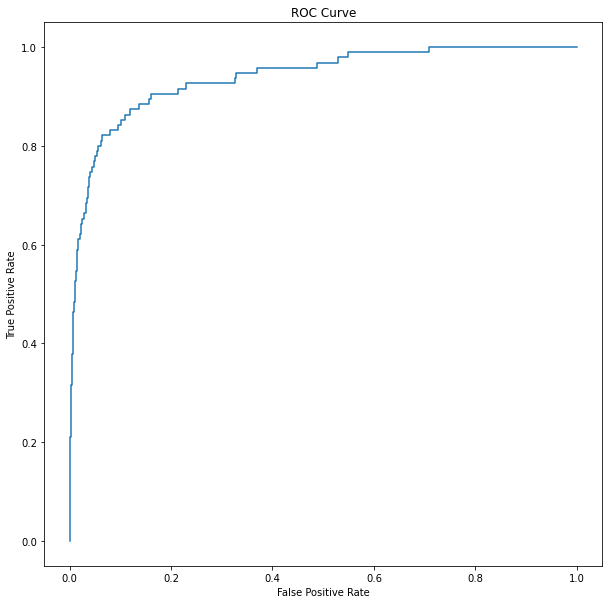

AUPRC: 0.11523340486456746


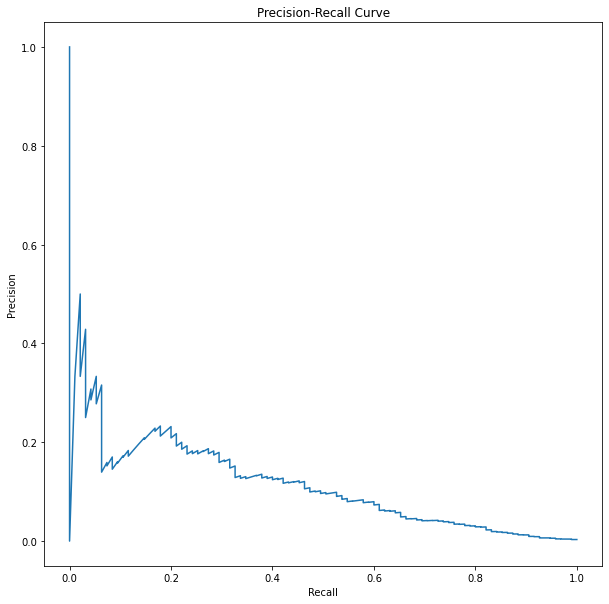

In [12]:
plot_result(X_val_1=X_test_1, X_val_2=X_test_2, X_val_3=X_test_3, y_val=y_test)

## External Validation

## Asan 

In [13]:
X_amc = df_amc[var_list]
X_amc.fillna(X_amc.median(), inplace=True)
X_amc_1 = X_amc.drop(columns=['asa'])
X_amc_2 = pd.get_dummies(X_amc['asa'], prefix='asa')
X_amc_3 = X_amc_2['asa_2']
X_amc_2 = X_amc_2['asa_1']

X_amc_1 = pd.DataFrame(scaler.transform(X_amc_1))
y_amc = df_amc['death30']*1

/home/khl256/anaconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


AUROC: 0.8939754960226753


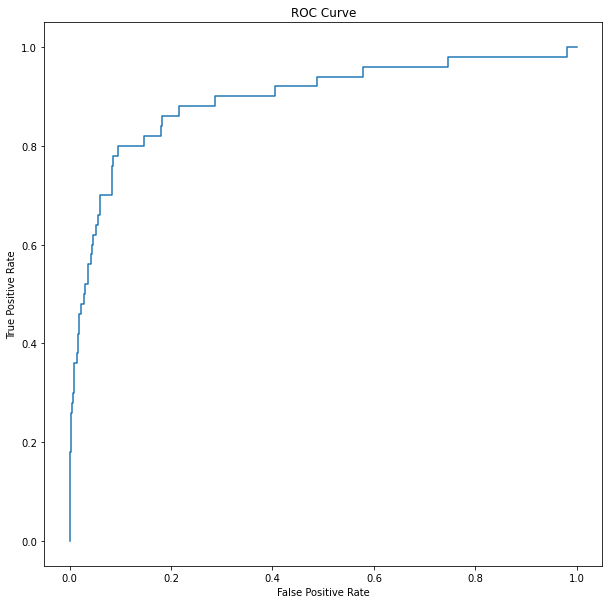

AUPRC: 0.10801477741040343


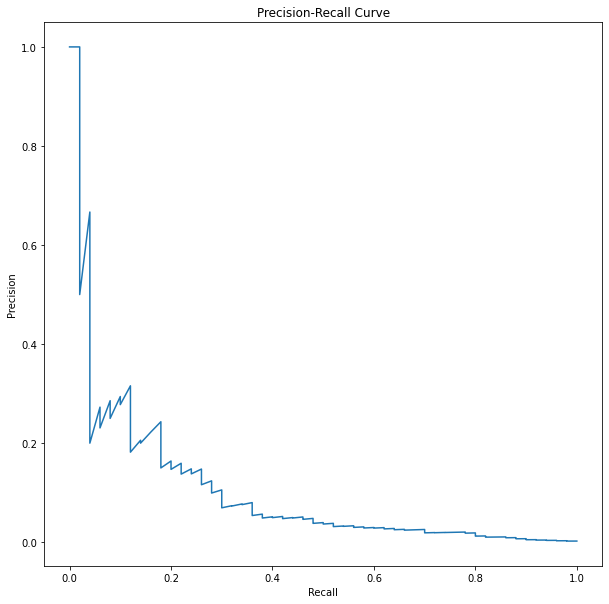

In [14]:
plot_result(X_val_1=X_amc_1, X_val_2=X_amc_2, X_val_3=X_amc_3, y_val=y_amc)

In [1]:
import pandas as pd

In [7]:
df = pd.DataFrame({'numbers': [1, 2, 3], 'colors': ['red', 'white', 'blue']})

In [8]:
df

,numbers,colors
0,1,red
1,2,white
2,3,blue
